## LIGO Noise Removal and Regression (Again!)
### Brendan King, Angelo Rustichini, Sid Suresh, Taarak Shah

In this presentation, we will explore different methods and practices for noise removal of LIGO data. In this notebook specifically, we will explore the impact of various random noise signals and obtain a working implementation of a neural network that can successfully remove noise from this sample, made up data. We explore various combinations of noise signals (very original, I know) to get a sense of how well our network can perform across different forms of noise.

Then, in the next portion of the presentation, we explored how these networks perform on real LIGO data and what changes are needed when facing this problem in an applied context.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.io as sio
import scipy.signal as sig
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM

First, we add in some sample data generously provided by Michael. We are given a way to define the true signal and some modifiers for various noise signals. We begin by only looking at one noise signal, and how we can handle this with our neural network. Later on, we add in additional noise signals in various combinations -- multiplied, added onto each other, in and out of phase (so the network can learn both the amplitude of the noise and the phase -- 2 parameters rather than one). We will explore these possibilities in this notebook.

In [2]:
# signal
dur = 32                  # seconds
sample_rate = 128         # sample rate
true_freq = 13.4          # true frequency of our signal

# noise 
noise_freq = 5.8          # frequency of our added noise
noise_phase = np.pi/4     # noise of our frequency
noise_amp = 0.25          # amplitude of noise signal

# time, 32 seconds
t = np.linspace(0, dur, dur*sample_rate)
# true signal
s = np.sin(2*np.pi*true_freq * t)
# added noise, want to subtract this
n = noise_amp * np.sin(2*np.pi*noise_freq*t + noise_phase)

# system output -- the signal with the noise
d = s + n

We begin with a simple implementation of the noise signal. Our goal is to separate the noise from our true signal, visualized below in the two plots. Our end goal is to obtain something that will approximate the orange line in the plot below using our neural network.

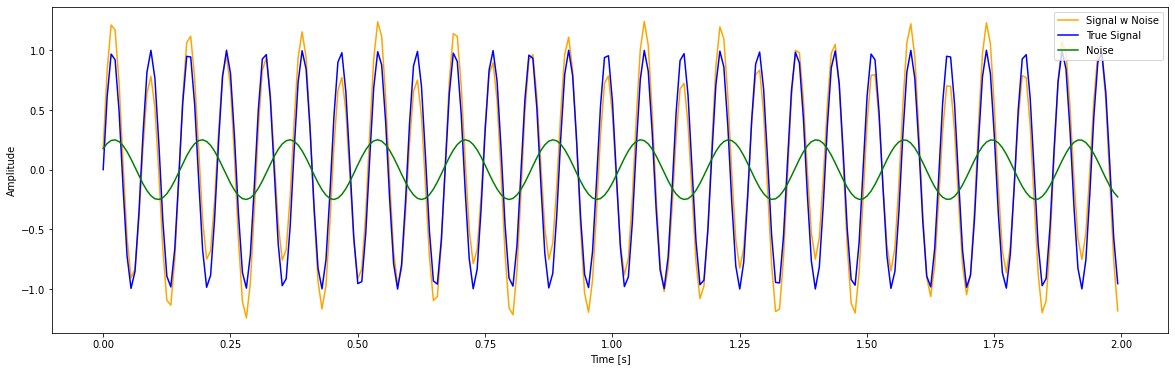

In [3]:
# plot the combined system output and the noise
# plots only first 2 seconds, it's repetitive after that
vis = 2 * sample_rate
fig = plt.figure(figsize=(20,6))
plt.plot(t[:vis], d[:vis], label='Signal w Noise', c='orange')
plt.plot(t[:vis], s[:vis], label='True Signal', c='b')
plt.plot(t[:vis], n[:vis], label='Noise', c='g')
plt.legend(loc='upper right')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()
plt.close()

Now, we have an idea of the structure of our data, and what we can expect when we begin to work with the real data. Our goal is to train on the noise and learn the patterns in the noise, and our "target" variable is the system output (the signal + the noise). We split the 32 seconds of our signal (given by ```dur``` in previous cells) into a 70/30 split, of 22 seconds for training and 10 seconds for testing.

In [4]:
# train on 22 seconds
x_train = n[:22*sample_rate]
y_train = d[:22*sample_rate]

# test on 10 seconds
x_test = n[22*sample_rate:]
y_test = d[22*sample_rate:]

Now, we build our first network. This is a very simple network with one hidden layer. We use the linear activation function, since our noise is not multiplied in to our signal, simply linearly added on to it. This is also called a pass-through layer, meaning it simply returns whatever input is given to it.

$$f(x) = x$$

This makes using a neural network for this problem incredibly useless, since we can do this job ourselves -- it's purely for demonstration on the framework of our presentation.

In [5]:
# build the network
# 1 hidden dense layer, linear activation function ('pass-through' layer)
# INCREDIBLY EXCITING!
model = Sequential()
model.add(Dense(2, input_dim=1, activation='linear'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
history = model.fit(x_train, y_train, epochs=60, validation_data=(x_test, y_test), batch_size=sample_rate, verbose=0)
y_hat = model.predict(x_test)

We can now plot the training and validation loss for our data and see how the network performs. Both converge to a small MSE, so we are confident that this network performs well.

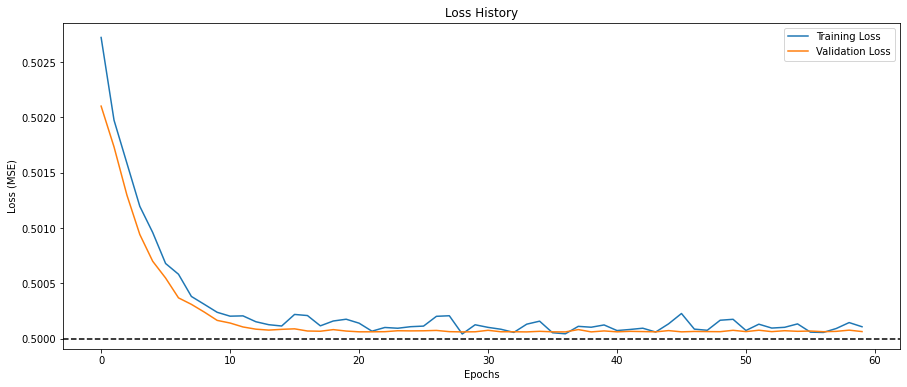

In [6]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(15,6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axhline(0.5, color='black', ls='--')
plt.legend()
plt.title('Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.show('sine_loss.png')
plt.close()

From here, we can see the approximation of our signal output from the neural network and visualize the difference between our true signal and our estimated signal, and determine the network's approximation of noise.

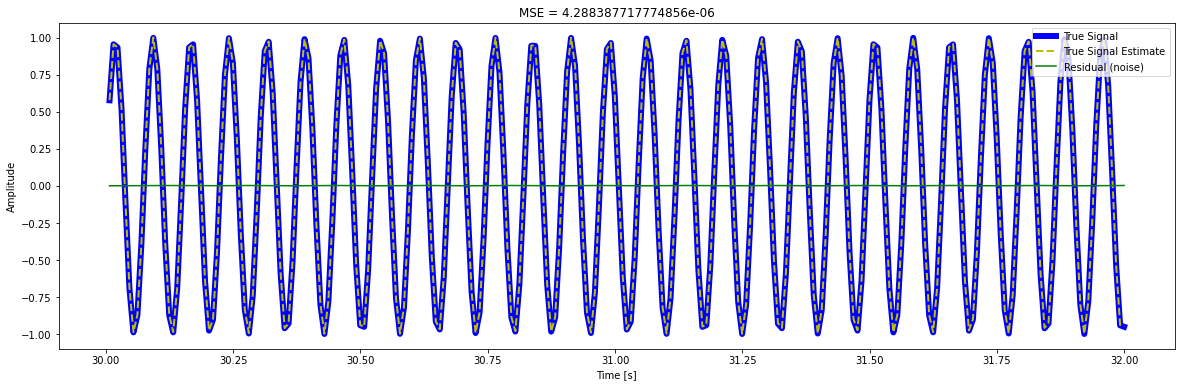

In [7]:
y_hat = y_hat.reshape(y_hat.size)
clean = y_test - y_hat
mse = ((clean[-2*sample_rate:] - s[-2*sample_rate:])**2).mean()

fig = plt.figure(figsize=(20,6))
# visualize approximation on test data
# anything after 30 seconds
plt.plot(t[30*sample_rate:], s[30*sample_rate:], label='True Signal', linewidth=6, c='b')
plt.plot(t[30*sample_rate:], clean[-2*sample_rate:], label='True Signal Estimate', ls='--', c='y', lw=2)
plt.plot(t[30*sample_rate:], (clean[-2*sample_rate:]-s[30*sample_rate:]), label='Residual (noise)', c='g')
plt.legend()
plt.title('MSE = {}'.format(mse))
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()
plt.close()

From above, we see in the yellow that the estimate essentially perfectly approximates the test data. This is something we could've done just as well on our own, since the noise is linearly added. We compute the power spectral density. The power spectral density (PSD) of the signal describes the power present in the signal as a function of frequency. This is another way to visualize the peaks in the signal versus the time-based signal alone. We can use the ```welch``` function from ```scipy.signal``` to convert our signals to PSDs.

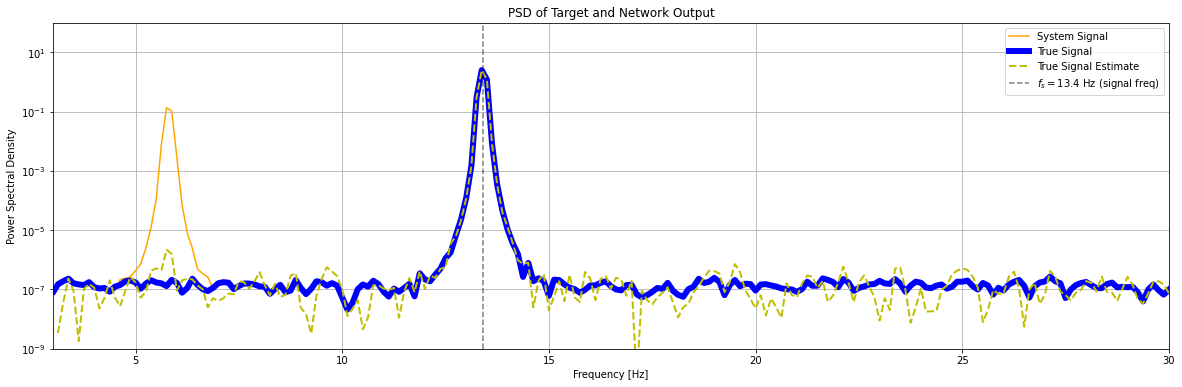

In [8]:
# implement PSD for residual, signal+noise, and true signal
fig = plt.figure(figsize=(20,6))
noise_floor = 0.01 * np.random.rand(s.size)
freq, clean_psd = sig.welch(clean+noise_floor[:clean.size], fs=sample_rate, nperseg=sample_rate*8)
_, signal_psd = sig.welch(s+noise_floor, fs=sample_rate, nperseg=sample_rate*8)
_, d_psd = sig.welch(d+noise_floor, fs=sample_rate, nperseg=sample_rate*8)
plt.semilogy(freq, d_psd, label='System Signal', c='orange')
plt.semilogy(freq, signal_psd, label='True Signal', lw=6, c='b')
plt.semilogy(freq, clean_psd, label='True Signal Estimate', ls='--', lw=2, c='y')
plt.axvline(true_freq, label='$f_s={}$ Hz (signal freq)'.format(true_freq), ls='--', color='black', alpha=0.5)
plt.legend(loc='upper right')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density')
plt.xlim([3, 30])
plt.ylim([1e-9, 1e2])
plt.grid(True)
plt.title('PSD of Target and Network Output')
plt.show()
plt.close()

In blue, we observe the system signal with the noise included. In orange, we see the true signal without the noise, this is what we wanted to approximate. In green, we see the estimate that our neural network output for the true signal. The green line very closely approximates the true signal without the noise, and it almost perfectly ignores the noise in the system signal.

## However...

This is a very simple noise function, linearly added to our observed signal. We could do this just as easily without building a neural network. What occurs if we try this same network on more complicated noise inputs? What if we have phase shifts? These are all occurrences that we may see in our real data, so we attempt to address it here before we move forward.

# More complicated noise inputs, same network

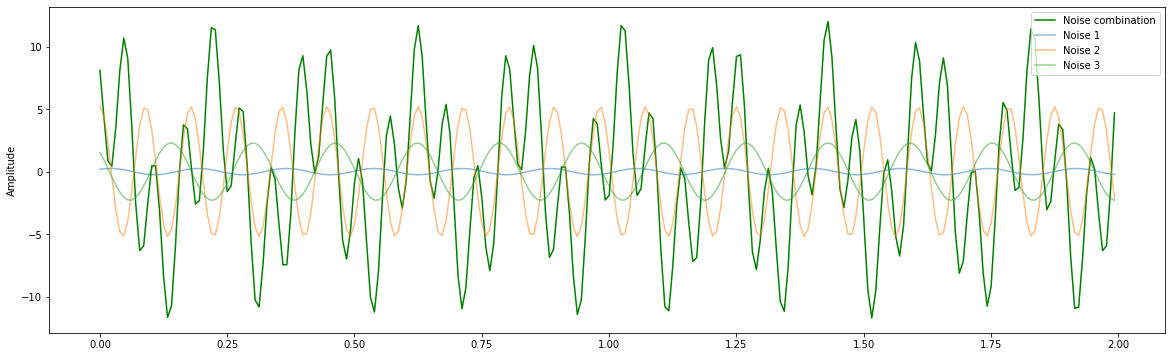

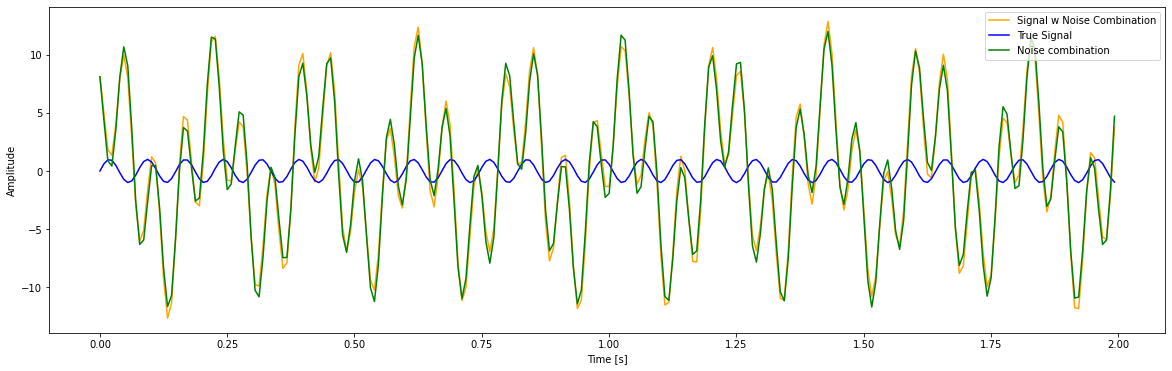

In [9]:
# signal
dur = 32                     # seconds
sample_rate = 128           # sample rate
true_freq = 13.4             # true frequency of our signal

# noise 1
noise_freq = 5.8             # frequency of our added noise
noise_phase = np.pi/4        # noise of our frequency
noise_amp = 0.25             # amplitude of noise signal

# noise 2
noise_freq2 = 11.2           # frequency of our added noise
noise_phase2 = np.pi/2       # noise of our frequency
noise_amp2 = 5.2             # amplitude of noise signal

# noise 3
noise_freq3 = 6.2            # frequency of our added noise
noise_phase3 = np.pi/1.3     # noise of our frequency
noise_amp3 = 2.3             # amplitude of noise signal

# time, 32 seconds
t = np.linspace(0, dur, dur*sample_rate)
# true signal
s = np.sin(2*np.pi*true_freq * t)
# added noise, want to subtract this
n = noise_amp * np.sin(2*np.pi*noise_freq*t + noise_phase)
n2 = noise_amp2 * np.sin(2*np.pi*noise_freq2*t + noise_phase2)
n3 = noise_amp3 * np.sin(2*np.pi*noise_freq3*t + noise_phase3)

# system output -- the signal with the noise
d = s + n + n2*n3

# plot the combined system output and the noise
# plots only first 2 seconds, it's repetitive after that
vis = 2 * sample_rate
fig = plt.figure(figsize=(20,6))
plt.plot(t[:vis], (n+n2*n3)[:vis], label='Noise combination', c='g')
plt.plot(t[:vis], n[:vis], label='Noise 1', alpha=0.5)
plt.plot(t[:vis], n2[:vis], label='Noise 2', alpha=0.5)
plt.plot(t[:vis], n3[:vis], label='Noise 3', alpha=0.5)
plt.legend(loc='upper right')
# plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()
plt.close()

fig = plt.figure(figsize=(20,6))
plt.plot(t[:vis], d[:vis], label='Signal w Noise Combination', c='orange')
plt.plot(t[:vis], s[:vis], label='True Signal', c='b')
plt.plot(t[:vis], (n+n2*n3)[:vis], label='Noise combination', c='g')
plt.legend(loc='upper right')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()

This is starting to look crazier -- our original noise is still added to the signal along with two other noise signals multiplied together. This is similar to what LIGO1 did in their analysis on the sample data, but as a reminder we'll go over again what works and what falls apart compared to our simple additive signal. First, we'll use the exact same neural network on this data and observe the performance.

In [10]:
noise = np.array([n,n2,n3]).T
# train on 22 seconds
x_train = noise[:22*sample_rate]
y_train = d[:22*sample_rate]

# test on 10 seconds
x_test = noise[22*sample_rate:]
y_test = d[22*sample_rate:]

# build the network
# 1 hidden dense layer, linear activation function ('pass-through' layer)
# INCREDIBLY EXCITING!
model = Sequential()
model.add(Dense(10, input_dim=x_train.shape[1], activation='linear'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
history = model.fit(x_train, y_train, epochs=60, validation_data=(x_test, y_test), batch_size=sample_rate, verbose=0)
y_hat = model.predict(x_test)

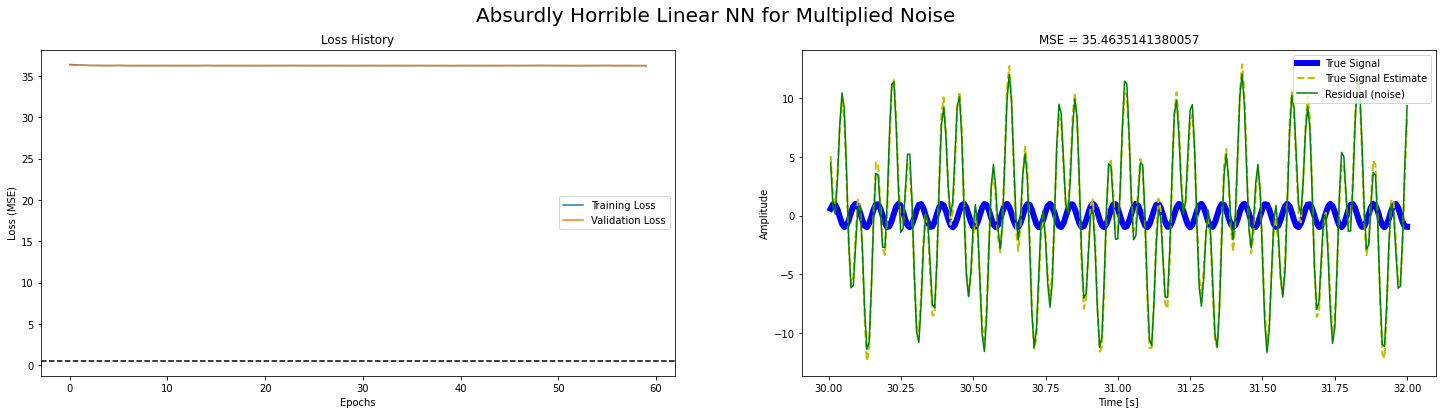

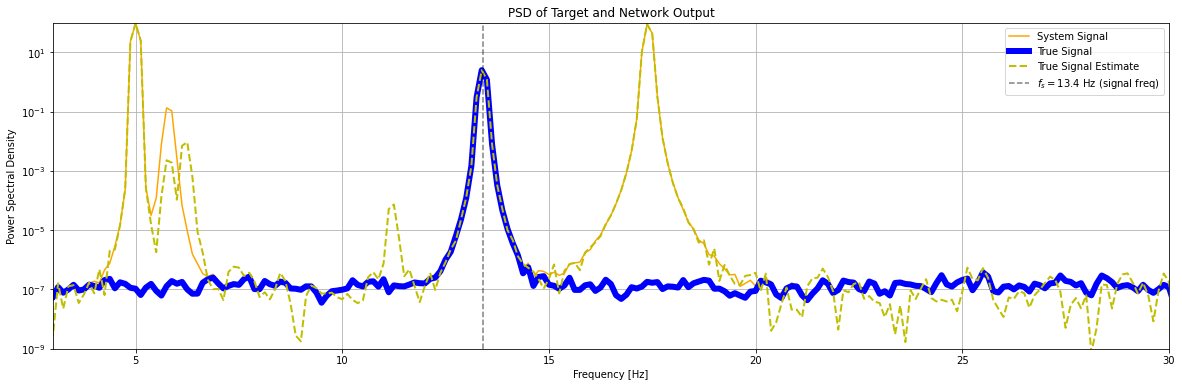

In [11]:
# plot loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(25,6))
fig.suptitle('Absurdly Horrible Linear NN for Multiplied Noise', fontsize=20)
ax1 = fig.add_subplot(121)
ax1.plot(train_loss, label='Training Loss')
ax1.plot(val_loss, label='Validation Loss')
ax1.axhline(0.5, color='black', ls='--')
ax1.legend()
ax1.set_title('Loss History')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss (MSE)')

# plot true vs est
y_hat = y_hat.reshape(y_hat.size)
clean = y_test - y_hat
mse = ((clean[-2*sample_rate:] - s[-2*sample_rate:])**2).mean()
# visualize approximation on test data
# anything after 30 seconds
ax2 = fig.add_subplot(122)
ax2.plot(t[30*sample_rate:], s[30*sample_rate:], label='True Signal', linewidth=6, c='b')
ax2.plot(t[30*sample_rate:], clean[-2*sample_rate:], label='True Signal Estimate', ls='--', c='y', lw=2)
ax2.plot(t[30*sample_rate:], (clean[-2*sample_rate:]-s[30*sample_rate:]), label='Residual (noise)', c='g')
ax2.legend()
ax2.set_title('MSE = {}'.format(mse))
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Amplitude')
plt.show()
plt.close()

# implement PSD for residual, signal+noise, and true signal
fig = plt.figure(figsize=(20,6))
noise_floor = 0.01 * np.random.rand(s.size)
freq, clean_psd = sig.welch(clean+noise_floor[:clean.size], fs=sample_rate, nperseg=sample_rate*8)
_, signal_psd = sig.welch(s+noise_floor, fs=sample_rate, nperseg=sample_rate*8)
_, d_psd = sig.welch(d+noise_floor, fs=sample_rate, nperseg=sample_rate*8)
plt.semilogy(freq, d_psd, label='System Signal', c='orange')
plt.semilogy(freq, signal_psd, label='True Signal', lw=6, c='b')
plt.semilogy(freq, clean_psd, label='True Signal Estimate', ls='--', lw=2, c='y')
plt.axvline(true_freq, label='$f_s={}$ Hz (signal freq)'.format(true_freq), ls='--', color='black', alpha=0.5)
plt.legend(loc='upper right')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density')
plt.xlim([3, 30])
plt.ylim([1e-9, 1e2])
plt.grid(True)
plt.title('PSD of Target and Network Output')
plt.show()
plt.close()

This is absolutely horrendous. The network with linear activation approximates the noise better than the actual signal, we are left with nothing useful looking at the PSD estimate. So, obviously, a linear activation is not the answer. What if we add an additional layer and try ReLU (rectified linear unit) or ELU (exponential linear unit) activation?

ReLU is defined as:
$$f(x) = 
\begin{cases}
0 & \text{if x<0}\\
x & \text{if x} \geq 0 \\
\end{cases} = max(0,x)
$$

and ELU is

$$f(x) = 
\begin{cases}
\alpha(e^x-1) & \text{if x<0}\\
x & \text{if x} \geq 0 \\
\end{cases}
$$

After attempting both cases, it was determined that RELU performed better than ELU on this noise approximation. Those results are reproduced below.

In [12]:
noise = np.array([n,n2,n3]).T
# train on 22 seconds
x_train = noise[:22*sample_rate]
y_train = d[:22*sample_rate]

# test on 10 seconds
x_test = noise[22*sample_rate:]
y_test = d[22*sample_rate:]

# build the network
# same number of nodes, 1 layer
# ReLU activation
model = Sequential()
model.add(Dense(10, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
history = model.fit(x_train, y_train, epochs=60, validation_data=(x_test, y_test), batch_size=sample_rate, verbose=0)
y_hat = model.predict(x_test)

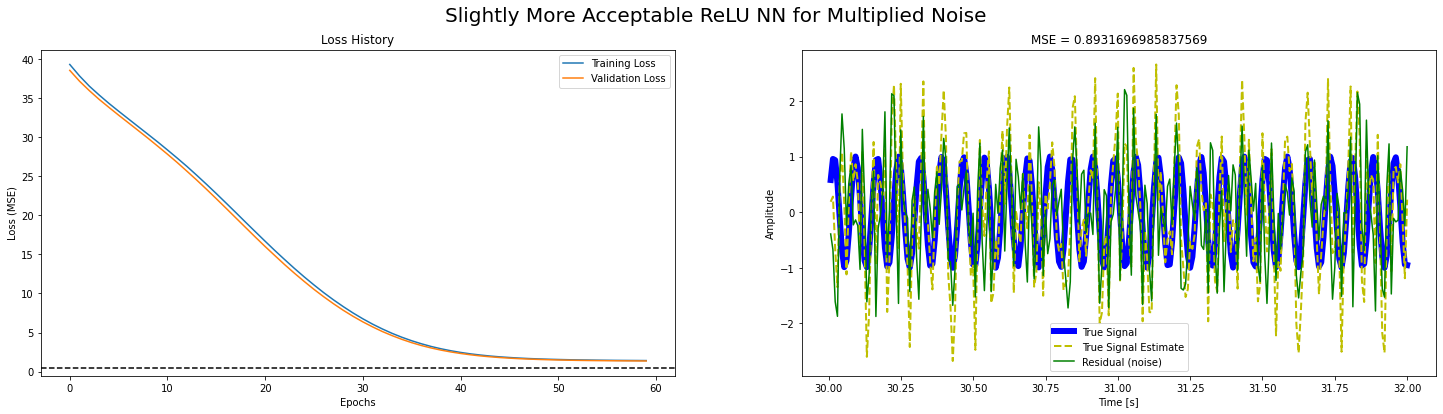

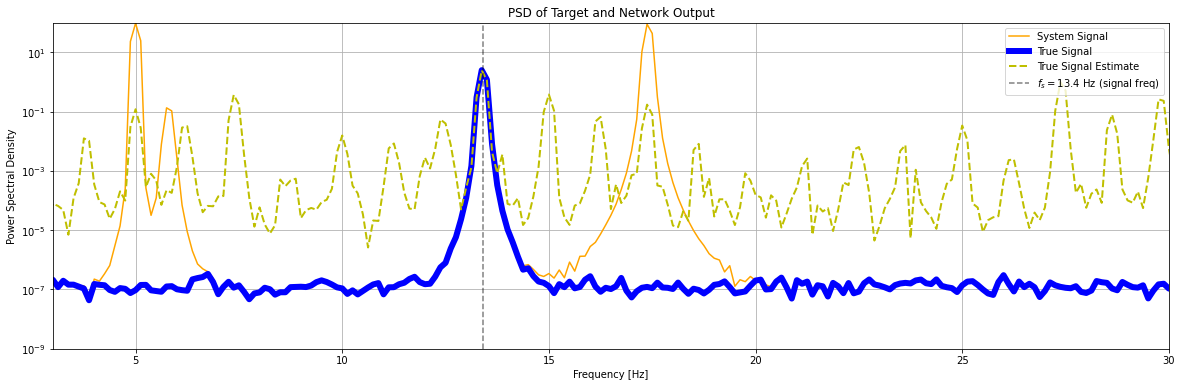

In [13]:
# plot loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(25,6))
fig.suptitle('Slightly More Acceptable ReLU NN for Multiplied Noise', fontsize=20)
ax1 = fig.add_subplot(121)
ax1.plot(train_loss, label='Training Loss')
ax1.plot(val_loss, label='Validation Loss')
ax1.axhline(0.5, color='black', ls='--')
ax1.legend()
ax1.set_title('Loss History')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss (MSE)')

# plot true vs est
y_hat = y_hat.reshape(y_hat.size)
clean = y_test - y_hat
mse = ((clean[-2*sample_rate:] - s[-2*sample_rate:])**2).mean()
# visualize approximation on test data
# anything after 30 seconds
ax2 = fig.add_subplot(122)
ax2.plot(t[30*sample_rate:], s[30*sample_rate:], label='True Signal', linewidth=6, c='b')
ax2.plot(t[30*sample_rate:], clean[-2*sample_rate:], label='True Signal Estimate', ls='--', c='y', lw=2)
ax2.plot(t[30*sample_rate:], (clean[-2*sample_rate:]-s[30*sample_rate:]), label='Residual (noise)', c='g')
ax2.legend()
ax2.set_title('MSE = {}'.format(mse))
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Amplitude')
plt.show()
plt.close()

# implement PSD for residual, signal+noise, and true signal
fig = plt.figure(figsize=(20,6))
noise_floor = 0.01 * np.random.rand(s.size)
freq, clean_psd = sig.welch(clean+noise_floor[:clean.size], fs=sample_rate, nperseg=sample_rate*8)
_, signal_psd = sig.welch(s+noise_floor, fs=sample_rate, nperseg=sample_rate*8)
_, d_psd = sig.welch(d+noise_floor, fs=sample_rate, nperseg=sample_rate*8)
plt.semilogy(freq, d_psd, label='System Signal', c='orange')
plt.semilogy(freq, signal_psd, label='True Signal', lw=6, c='b')
plt.semilogy(freq, clean_psd, label='True Signal Estimate', ls='--', lw=2, c='y')
plt.axvline(true_freq, label='$f_s={}$ Hz (signal freq)'.format(true_freq), ls='--', color='black', alpha=0.5)
plt.legend(loc='upper right')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density')
plt.xlim([3, 30])
plt.ylim([1e-9, 1e2])
plt.grid(True)
plt.title('PSD of Target and Network Output')
plt.show()
plt.close()

# How can we improve the performance with unpredictable noise combinations?

We will try a couple methods here:

1. Our input data will be "groups" of points over 2 second chunks rather than individual data points. This helps to give the network an idea of how the points are organized rather than having it make all associations on its own. We will use ReLU activation first for this method, then RNNs and LSTMs.

2. We will use a recurrent neural network (RNN) -- to simplify it, this is a vanilla version of the LSTM. It takes in chunks of data and forms connections in a temporal manner.

3. We will use LSTMs, a more advanced version of an RNN developed from the same framework.

https://ai.stackexchange.com/questions/18198/what-s-the-difference-between-lstm-and-rnn

# Data Chunks with ReLU



In [14]:
# signal, rewritten for convenience
dur = 512                     # seconds
sample_rate = 128           # sample rate
true_freq = 13.4             # true frequency of our signal

# noise 1
noise_freq = 5.8             # frequency of our added noise
noise_phase = np.pi/4        # noise of our frequency
noise_amp = 0.25             # amplitude of noise signal

# noise 2
noise_freq2 = 11.2           # frequency of our added noise
noise_phase2 = np.pi/2       # noise of our frequency
noise_amp2 = 5.2             # amplitude of noise signal

# noise 3
noise_freq3 = 6.2            # frequency of our added noise
noise_phase3 = np.pi/1.3     # noise of our frequency
noise_amp3 = 2.3             # amplitude of noise signal

# time, 32 seconds
t = np.linspace(0, dur, dur*sample_rate)
# true signal
s = np.sin(2*np.pi*true_freq * t)
# added noise, want to subtract this
n = noise_amp * np.sin(2*np.pi*noise_freq*t + noise_phase)
n2 = noise_amp2 * np.sin(2*np.pi*noise_freq2*t + noise_phase2)
n3 = noise_amp3 * np.sin(2*np.pi*noise_freq3*t + noise_phase3)

# system output -- the signal with the noise
d = s + n + n2*n3

# build train and test sets
# splitting data into 1 second chunks for our 3 noise channels
noise = np.array([n,n2,n3]).T
input_data = np.zeros((dur, sample_rate, 3)) # (512, 128, 3)
target_data = np.zeros((dur, sample_rate)) # (512, 128)
for i in range(dur):
    st = i*sample_rate
    et = (i+1)*sample_rate
    input_data[i,:] = noise[st:et]
    target_data[i,:] = d[st:et]

# train on 512*0.8 = 410 seconds
x_train = input_data[:410, :]
y_train = target_data[:410, :]

# test on the rest
x_test = input_data[410:, :]
y_test = target_data[410:, :]

print('x_train, y_train', x_train.shape, y_train.shape)
print('x_test, y_test', x_test.shape, y_test.shape)

x_train, y_train (410, 128, 3) (410, 128)
x_test, y_test (102, 128, 3) (102, 128)


In [15]:
# build the network
# ReLU activation
model = Sequential()
model.add(Dense(10, input_shape=(x_train.shape[1], x_train.shape[2]), activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
history = model.fit(x_train, y_train, epochs=60, validation_data=(x_test, y_test), batch_size=sample_rate, verbose=0)
y_hat = model.predict(x_test)

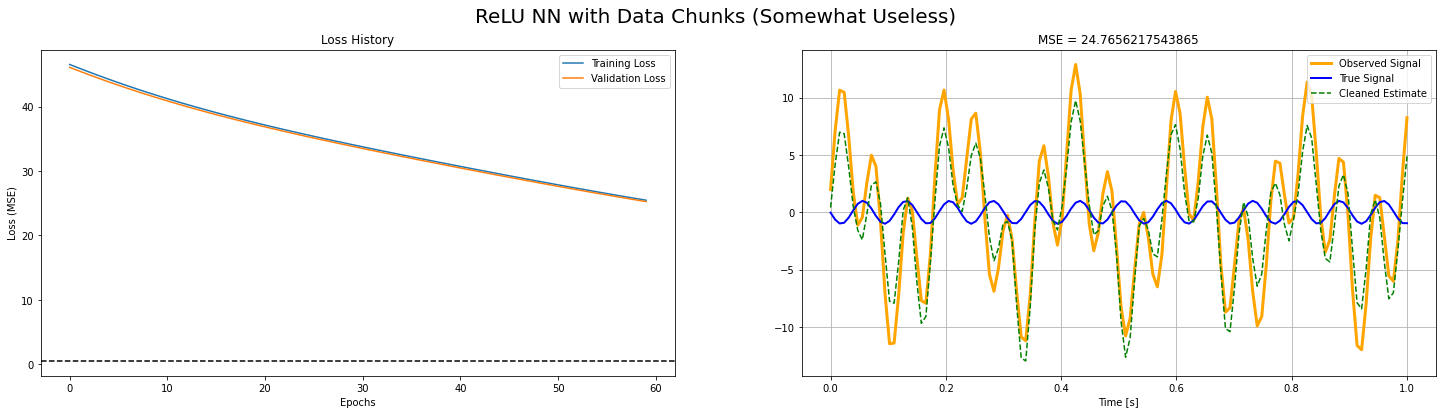

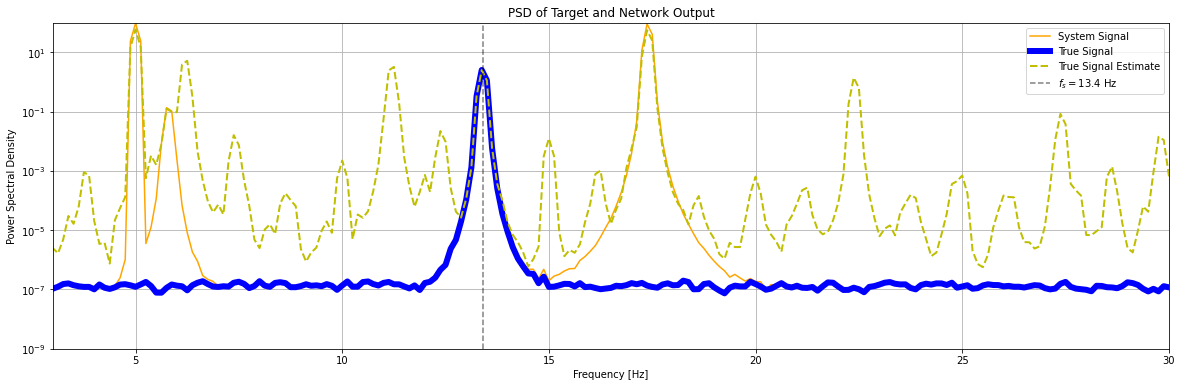

In [16]:
# plot loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(25,6))
fig.suptitle('ReLU NN with Data Chunks (Somewhat Useless)', fontsize=20)
ax1 = fig.add_subplot(121)
ax1.plot(train_loss, label='Training Loss')
ax1.plot(val_loss, label='Validation Loss')
ax1.axhline(0.5, color='black', ls='--')
ax1.legend()
ax1.set_title('Loss History')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss (MSE)')

# plot true vs est
clean = y_test.flatten() - y_hat.flatten()
mse = ((clean - s[-sample_rate*y_test.shape[0]:])**2).mean()
# visualize approximation on test data
time = np.linspace(0, 1, sample_rate)
ax2 = fig.add_subplot(122)
ax2.plot(time, y_test.flatten()[-sample_rate:], label='Observed Signal', lw=3.0, c='orange')
ax2.plot(time, s[-sample_rate:], label='True Signal', lw=2.0, c='b')
ax2.plot(time, clean[-sample_rate:], label='Cleaned Estimate', ls='--', c='g')
ax2.legend(loc='upper right')
ax2.grid(True)
ax2.set_xlabel('Time [s]')
ax2.set_title('MSE = {}'.format(mse))
plt.show()
plt.close()

# implement PSD for residual, signal+noise, and true signal
fig = plt.figure(figsize=(20,6))

noise_floor = 0.01 * np.random.rand(clean.size)
freq, clean_psd = sig.welch(clean+noise_floor, fs=sample_rate, nperseg=sample_rate*8)
_, signal_psd = sig.welch(s[-clean.size:]+noise_floor, fs=sample_rate, nperseg=sample_rate*8)
_, d_psd = sig.welch(d[-clean.size:]+noise_floor, fs=sample_rate, nperseg=sample_rate*8)
plt.semilogy(freq, d_psd, label='System Signal', c='orange')
plt.semilogy(freq, signal_psd, label='True Signal', lw=6, c='b')
plt.semilogy(freq, clean_psd, label='True Signal Estimate', ls='--', lw=2, c='y')
plt.axvline(true_freq, label='$f_s={}$ Hz'.format(true_freq), ls='--', color='black', alpha=0.5)
plt.legend(loc='upper right')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density')
plt.xlim([3,30])
plt.ylim([1e-9, 1e2])
plt.grid(True)
plt.title('PSD of Target and Network Output')
plt.show()
plt.close()

While this was a neat exercise and provided some useful experimentation with signal processing, the results are ultimately quite useless. The true signal estimate has an incredible amount of peaks. This is just an indication that ReLU is not useful for time series when processing chunks of points rather than individual points. We move on to test out layers that are specifically designed to handle this type of chunk inputs in our data.

# Simple RNN

An RNN is a recurrent neural network. This differs from a feed-forward network, since instead of building up a connected network with different nodes, as we were before. Instead, RNNs work by saving the output of a specific layer, then it feeds that output back into the input of the layer to predict the output. A comparison is visualized below.

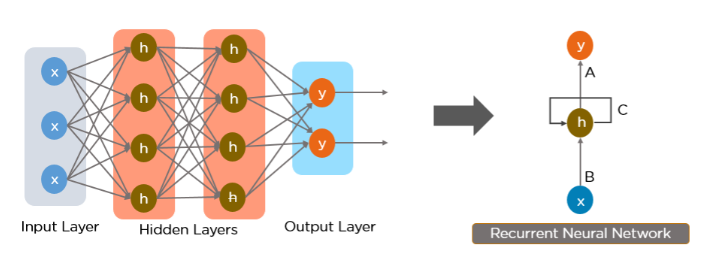

https://www.simplilearn.com/tutorials/deep-learning-tutorial/rnn


First, we define a function that will split our layered noises into chunks for the RNN and LSTM framework, then we run the network and produce our usual 3 plots.

In [17]:
def do_lookback(data, steps=1, validation=False):
    temp = np.zeros((data.shape[0] - steps, steps + 1, data.shape[1]))
    temp[:, 0, :] = data[steps:, :]
    for i in range(temp.shape[0]):
        temp[i, 1:] = data[i:i + steps][::-1]

    if validation:
        temp = temp.reshape((temp.shape[0], temp.shape[1]))

    for i in range(temp.shape[0]):
        temp[i, :] = temp[i, :][::-1]

    return temp

# apply lookback 
lb = 8
wit_lb = do_lookback(noise, lb)
tar_lb = d[lb:]

# training, testing sets
tfrac = 102*sample_rate
x_train = wit_lb[:-tfrac,:,:]
y_train = tar_lb[:-tfrac]

x_test = wit_lb[-tfrac:,:,:]
y_test = tar_lb[-tfrac:]

# tt = 8  # test time in seconds
# tfrac = 8*sample_rate
# x_train = wit_lb[:-tfrac, :, :]
# y_train = tar_lb[:-tfrac]

print('(samples, lookback, features)\n\n',x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(samples, lookback, features)

 (52472, 9, 3) (52472,) (13056, 9, 3) (13056,)


In [18]:
# build the network
# SimpleRNN
model = Sequential()
model.add(SimpleRNN(4, input_shape=(x_train.shape[1], x_train.shape[2]), activation='tanh'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
history = model.fit(x_train, y_train, epochs=60, validation_data=(x_test, y_test), batch_size=1000, verbose=0)
y_hat = model.predict(x_test)

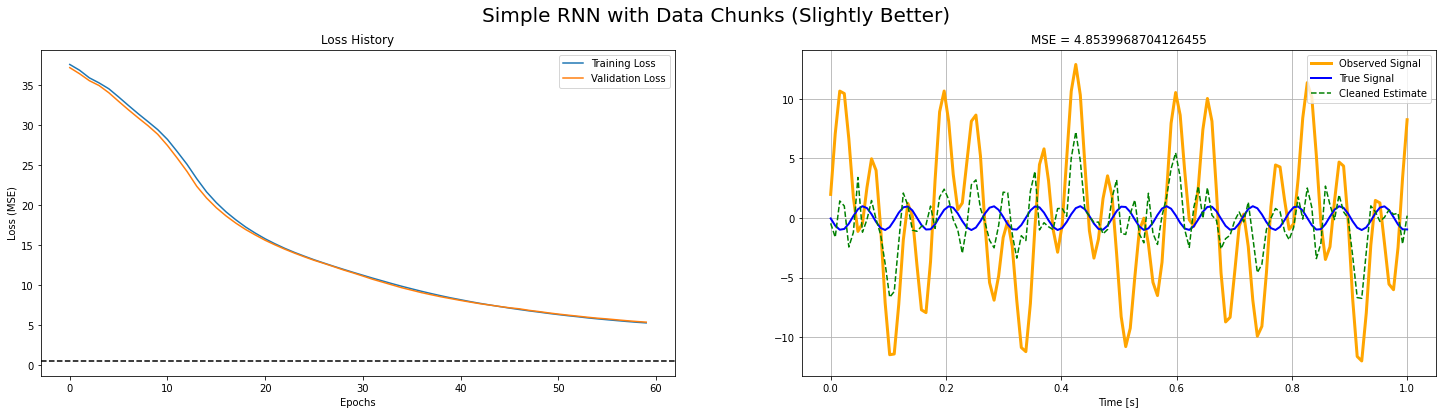

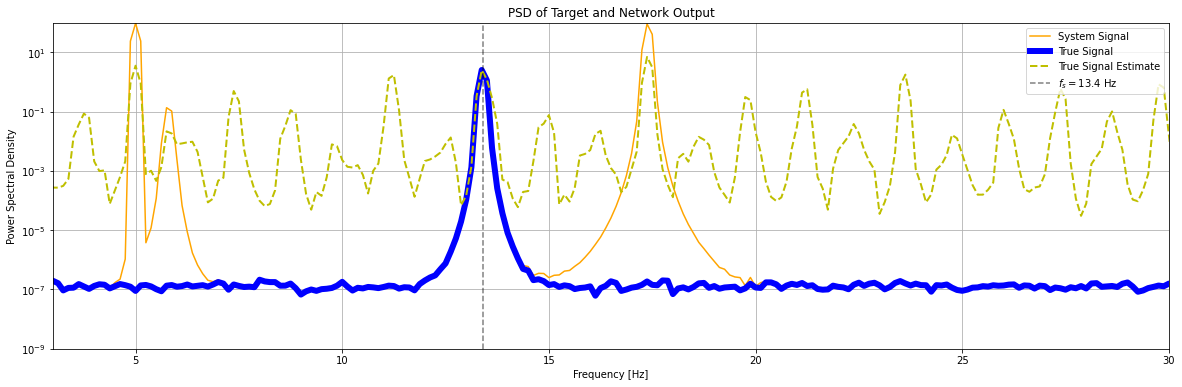

In [19]:
# plot loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(25,6))
fig.suptitle('Simple RNN with Data Chunks (Slightly Better)', fontsize=20)
ax1 = fig.add_subplot(121)
ax1.plot(train_loss, label='Training Loss')
ax1.plot(val_loss, label='Validation Loss')
ax1.axhline(0.5, color='black', ls='--')
ax1.legend()
ax1.set_title('Loss History')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss (MSE)')

# plot true vs est
clean = y_test - y_hat.flatten()
mse = ((clean[-2*sample_rate:] - s[-2*sample_rate:])**2).mean()
# visualize approximation on test data
time = np.linspace(0, 1, sample_rate)
ax2 = fig.add_subplot(122)
ax2.plot(time, y_test.flatten()[-sample_rate:], label='Observed Signal', lw=3.0, c='orange')
ax2.plot(time, s[-sample_rate:], label='True Signal', lw=2.0, c='b')
ax2.plot(time, clean[-sample_rate:], label='Cleaned Estimate', ls='--', c='g')
ax2.legend(loc='upper right')
ax2.grid(True)
ax2.set_xlabel('Time [s]')
ax2.set_title('MSE = {}'.format(mse))
plt.show()
plt.close()

# implement PSD for residual, signal+noise, and true signal
fig = plt.figure(figsize=(20,6))

noise_floor = 0.01 * np.random.rand(clean.size)
freq, clean_psd = sig.welch(clean+noise_floor, fs=sample_rate, nperseg=sample_rate*8)
_, signal_psd = sig.welch(s[-clean.size:]+noise_floor, fs=sample_rate, nperseg=sample_rate*8)
_, d_psd = sig.welch(d[-clean.size:]+noise_floor, fs=sample_rate, nperseg=sample_rate*8)
plt.semilogy(freq, d_psd, label='System Signal', c='orange')
plt.semilogy(freq, signal_psd, label='True Signal', lw=6, c='b')
plt.semilogy(freq, clean_psd, label='True Signal Estimate', ls='--', lw=2, c='y')
plt.axvline(true_freq, label='$f_s={}$ Hz'.format(true_freq), ls='--', color='black', alpha=0.5)
plt.legend(loc='upper right')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density')
plt.xlim([3,30])
plt.ylim([1e-9, 1e2])
plt.grid(True)
plt.title('PSD of Target and Network Output')
plt.show()
plt.close()

This is still not great -- it does underapproximate the peaks from our multiplied noise, but the estimated signal produces so many other peaks on the same order of magnitude as our true signal. This won't be helpful for a real example of signal detection where we can't compare to a true signal.

# What if we mix SimpleRNN with ReLU?

Now, we just try a mix of a feedforward NN and RNN. Surprisingly, this approximates our true signal fairly well.

In [20]:
# build the network
# SimpleRNN with ReLU
model = Sequential()
model.add(SimpleRNN(4, input_shape=(x_train.shape[1], x_train.shape[2]), activation='tanh'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
history = model.fit(x_train, y_train, epochs=60, validation_data=(x_test, y_test), batch_size=1000, verbose=0)
y_hat = model.predict(x_test)

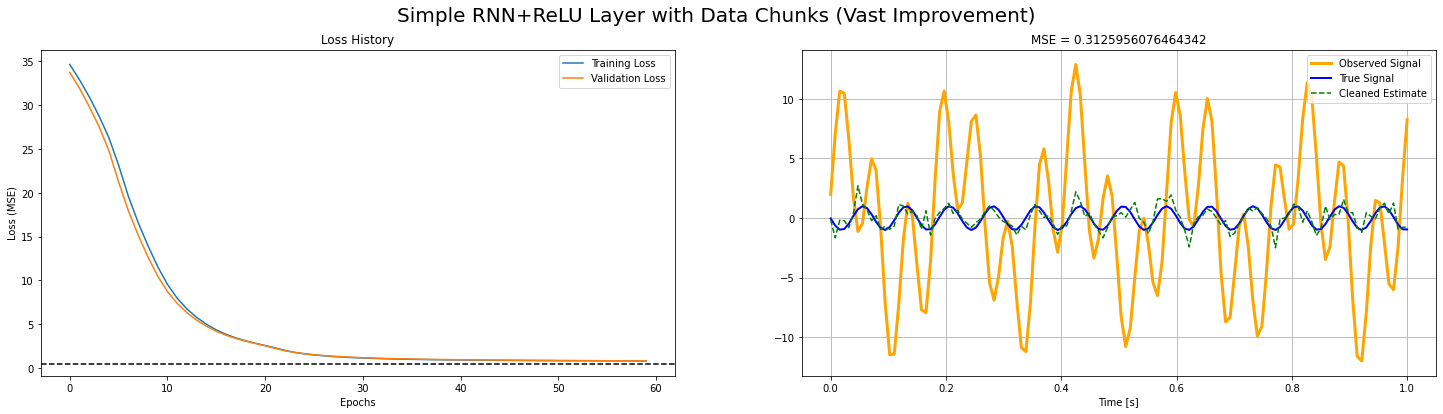

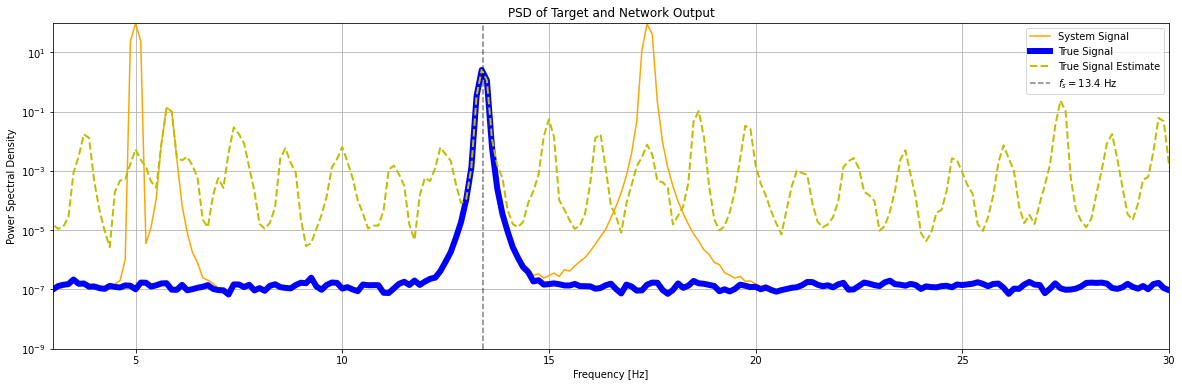

In [21]:
# plot loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(25,6))
fig.suptitle('Simple RNN+ReLU Layer with Data Chunks (Vast Improvement)', fontsize=20)
ax1 = fig.add_subplot(121)
ax1.plot(train_loss, label='Training Loss')
ax1.plot(val_loss, label='Validation Loss')
ax1.axhline(0.5, color='black', ls='--')
ax1.legend()
ax1.set_title('Loss History')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss (MSE)')

# plot true vs est
clean = y_test - y_hat.flatten()
mse = ((clean[-2*sample_rate:] - s[-2*sample_rate:])**2).mean()
# visualize approximation on test data
time = np.linspace(0, 1, sample_rate)
ax2 = fig.add_subplot(122)
ax2.plot(time, y_test.flatten()[-sample_rate:], label='Observed Signal', lw=3.0, c='orange')
ax2.plot(time, s[-sample_rate:], label='True Signal', lw=2.0, c='b')
ax2.plot(time, clean[-sample_rate:], label='Cleaned Estimate', ls='--', c='g')
ax2.legend(loc='upper right')
ax2.grid(True)
ax2.set_xlabel('Time [s]')
ax2.set_title('MSE = {}'.format(mse))
plt.show()
plt.close()

# implement PSD for residual, signal+noise, and true signal
fig = plt.figure(figsize=(20,6))

noise_floor = 0.01 * np.random.rand(clean.size)
freq, clean_psd = sig.welch(clean+noise_floor, fs=sample_rate, nperseg=sample_rate*8)
_, signal_psd = sig.welch(s[-clean.size:]+noise_floor, fs=sample_rate, nperseg=sample_rate*8)
_, d_psd = sig.welch(d[-clean.size:]+noise_floor, fs=sample_rate, nperseg=sample_rate*8)
plt.semilogy(freq, d_psd, label='System Signal', c='orange')
plt.semilogy(freq, signal_psd, label='True Signal', lw=6, c='b')
plt.semilogy(freq, clean_psd, label='True Signal Estimate', ls='--', lw=2, c='y')
plt.axvline(true_freq, label='$f_s={}$ Hz'.format(true_freq), ls='--', color='black', alpha=0.5)
plt.legend(loc='upper right')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density')
plt.xlim([3,30])
plt.ylim([1e-9, 1e2])
plt.grid(True)
plt.title('PSD of Target and Network Output')
plt.show()
plt.close()

The estimated signal gives us peaks that are about 2-3 orders of magnitude smaller than our true signal peak. This is a good example of how we can simply pick out our signals that are orders of magnitude higher and examine those more closely in our real data.

# LSTM

An LSTM is a special kind of RNN which learns long-term dependencies on the data depending on weights that are assigned to previous "chunks" of data that are passed into it. The algorithm is much more complex, increasing the runtime and making it less computationally efficient, but the tradeoff in performance is significant as we will show here and in our real data.

In [22]:
# build the network
# LSTM
model = Sequential()
model.add(LSTM(4, input_shape=(x_train.shape[1], x_train.shape[2]), activation='elu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
history = model.fit(x_train, y_train, epochs=60, validation_data=(x_test, y_test), batch_size=1000, verbose=0)
y_hat = model.predict(x_test)

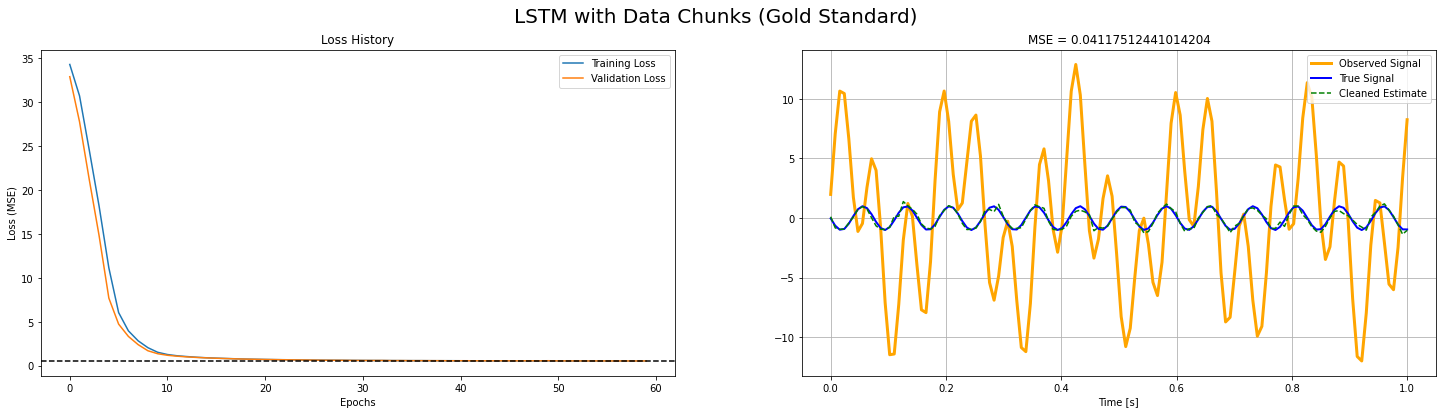

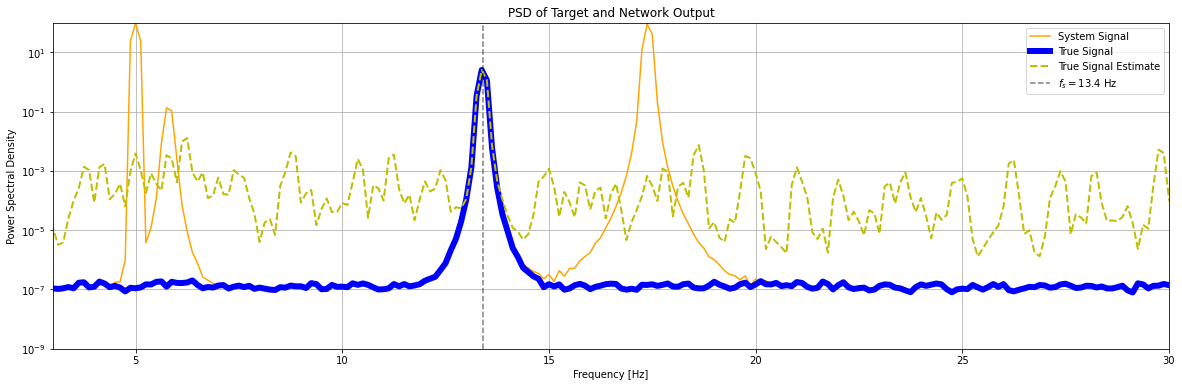

In [23]:
# plot loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(25,6))
fig.suptitle('LSTM with Data Chunks (Gold Standard)', fontsize=20)
ax1 = fig.add_subplot(121)
ax1.plot(train_loss, label='Training Loss')
ax1.plot(val_loss, label='Validation Loss')
ax1.axhline(0.5, color='black', ls='--')
ax1.legend()
ax1.set_title('Loss History')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss (MSE)')

# plot true vs est
clean = y_test - y_hat.flatten()
mse = ((clean[-2*sample_rate:] - s[-2*sample_rate:])**2).mean()
# visualize approximation on test data
time = np.linspace(0, 1, sample_rate)
ax2 = fig.add_subplot(122)
ax2.plot(time, y_test.flatten()[-sample_rate:], label='Observed Signal', lw=3.0, c='orange')
ax2.plot(time, s[-sample_rate:], label='True Signal', lw=2.0, c='b')
ax2.plot(time, clean[-sample_rate:], label='Cleaned Estimate', ls='--', c='g')
ax2.legend(loc='upper right')
ax2.grid(True)
ax2.set_xlabel('Time [s]')
ax2.set_title('MSE = {}'.format(mse))
plt.show()
plt.close()

# implement PSD for residual, signal+noise, and true signal
fig = plt.figure(figsize=(20,6))

noise_floor = 0.01 * np.random.rand(clean.size)
freq, clean_psd = sig.welch(clean+noise_floor, fs=sample_rate, nperseg=sample_rate*8)
_, signal_psd = sig.welch(s[-clean.size:]+noise_floor, fs=sample_rate, nperseg=sample_rate*8)
_, d_psd = sig.welch(d[-clean.size:]+noise_floor, fs=sample_rate, nperseg=sample_rate*8)
plt.semilogy(freq, d_psd, label='System Signal', c='orange')
plt.semilogy(freq, signal_psd, label='True Signal', lw=6, c='b')
plt.semilogy(freq, clean_psd, label='True Signal Estimate', ls='--', lw=2, c='y')
plt.axvline(true_freq, label='$f_s={}$ Hz'.format(true_freq), ls='--', color='black', alpha=0.5)
plt.legend(loc='upper right')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density')
plt.xlim([3,30])
plt.ylim([1e-9, 1e2])
plt.grid(True)
plt.title('PSD of Target and Network Output')
plt.show()
plt.close()

We observe an even greater difference in our signal estimate in terms of the order of magnitude. This is very useful for our approximation, indicating we can pick out where our important signals occur in real data. Now, we address what's next and working with something real and much more complex.

# What's left:

*   Run these different networks (linear, relu, lstm) on real data
*   Which noise channels are useful in our real data?

# Implementing Real LIGO Data

In [24]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [25]:
# load in the real data
fs_fast, fs_slow, dur = 256, 16, 2048  # Sampling rates and segment duration
st = 1242457832  # GPS Start Time
et = st + dur    # GPS End Time
flow, fhigh = 56, 64  # frequency band of interest

import scipy.io as sio
darm = sio.loadmat('/content/drive/My Drive/data/darm.mat')['data']
pem = sio.loadmat('/content/drive/My Drive/data/pem.mat')['data']
asc = sio.loadmat('/content/drive/My Drive/data/asc.mat')['data']
#asc = sig.resample(asc[1:5, :], dur*fs_fast, axis=1) # Uses just 4 ASC channels instead of 20
darm_chan = 'H1:GDS-CALIB_STRAIN'
pem_chan  = 'H1:PEM-CS_MAINSMON_EBAY_1_DQ'
asc_chans = ['H1:ASC-PRC1_Y_INMON',
             'H1:ASC-PRC2_P_INMON',
             'H1:ASC-SRC2_Y_INMON',
             'H1:ASC-DHARD_Y_INMON',
             'H1:ASC-INP1_P_INMON',
             'H1:ASC-INP1_Y_INMON',
             'H1:ASC-MICH_P_INMON',
             'H1:ASC-MICH_Y_INMON',
             'H1:ASC-PRC1_P_INMON',
             'H1:ASC-PRC2_Y_INMON',
             'H1:ASC-SRC1_P_INMON',
             'H1:ASC-SRC1_Y_INMON',
             'H1:ASC-SRC2_P_INMON',
             'H1:ASC-DHARD_P_INMON',
             'H1:ASC-CHARD_P_INMON',
             'H1:ASC-CHARD_Y_INMON',
             'H1:ASC-DSOFT_P_INMON',
             'H1:ASC-DSOFT_Y_INMON',
             'H1:ASC-CSOFT_P_INMON',
             'H1:ASC-CSOFT_Y_INMON']

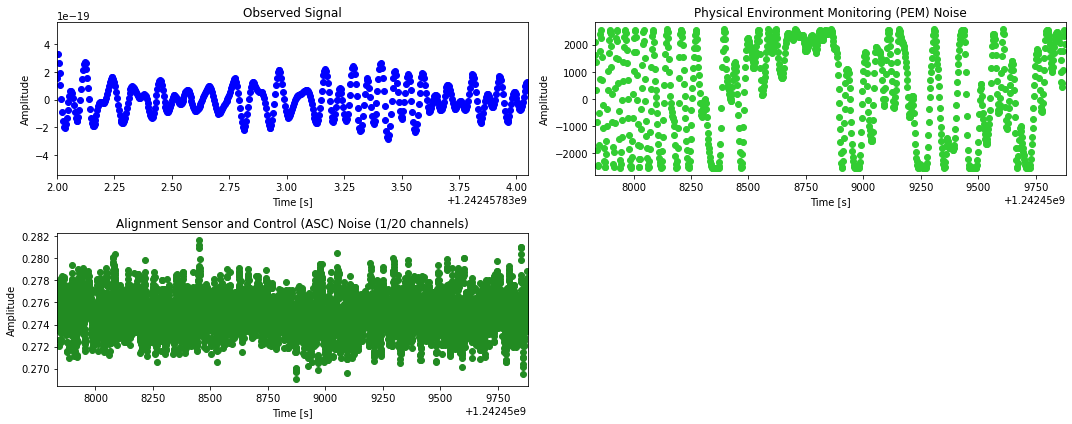

In [26]:
# visualize darm, pem, asc channel
t_fast = np.linspace(st, et, dur*fs_fast)
t_slow = np.linspace(st, et, dur*fs_slow)

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)

ax1.scatter(t_fast, darm, label='DARM (Signal w Noise)', c='b')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Amplitude')
ax1.set_xlim(st, st+dur/1000)
ax1.set_title('Observed Signal')

ax2.scatter(t_fast[::(2*fs_fast)], pem.T[::(2*fs_fast)], label='PEM (Noise Channel)', c='limegreen')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Amplitude')
ax2.set_xlim(st, et)
ax2.set_title('Physical Environment Monitoring (PEM) Noise')

ax3.scatter(t_fast[::4*fs_slow], asc[0][::4], label='ASC 0', c='forestgreen')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Amplitude')
ax3.set_xlim(st, et)
ax3.set_title('Alignment Sensor and Control (ASC) Noise (1/20 channels)')

plt.tight_layout()
plt.show()
plt.close()

This is pretty meaningless without any context of the peaks in our signal. We produce the PSD plots for these channels below.

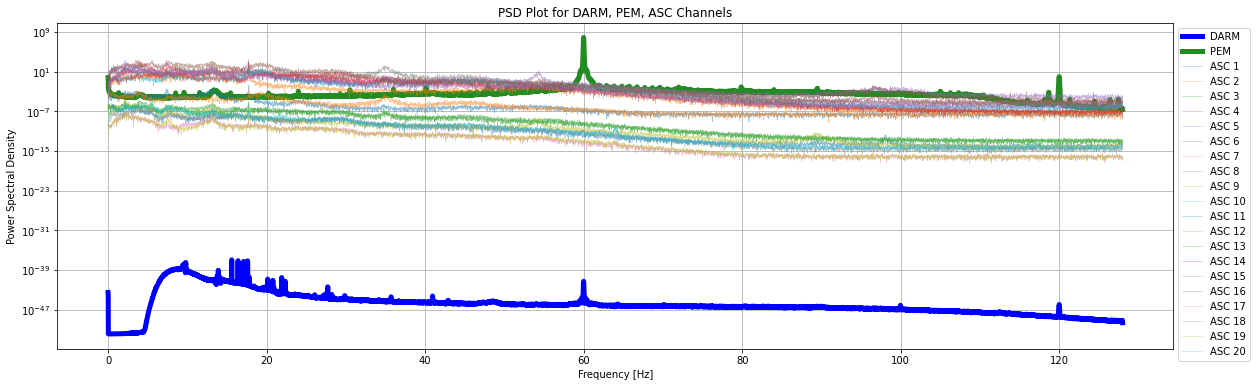

In [27]:
# visualize darm, pem, asc PSDs
fig = plt.figure(figsize=(20,6))
freqs, darm_psd = sig.welch(darm, fs=fs_fast, nperseg=fs_fast*60)
_, mains_psd = sig.welch(pem, fs=fs_fast, nperseg=fs_fast*60)
_, asc1_psd = sig.welch(asc[0 ,:], fs=fs_fast, nperseg=fs_fast*60)
plt.semilogy(freqs, darm_psd.flatten(), label='DARM', c='b', lw=5)
plt.semilogy(freqs, mains_psd.flatten(), label='PEM', c='forestgreen', lw=5)
for i in range(asc.shape[0]):
  _, asc_psd = sig.welch(asc[i ,:], fs=fs_fast, nperseg=fs_fast*60)
  plt.semilogy(freqs, asc_psd.flatten(), label='ASC {}'.format(i+1), alpha=0.5, lw=0.5)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.grid(True)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density')
plt.title('PSD Plot for DARM, PEM, ASC Channels')
plt.show()
plt.close()

From the above plot, we see that our observed signals and the noise measurements vary widely in orders of magnitude. The best option here is to normalize ALL of the channels and work with that data. We do this and plot the PSD again.

In [28]:
darm = (darm - np.mean(darm))/np.std(darm)
pem = (pem - np.mean(pem))/np.std(pem)
# normalize each column
for i in range(asc.shape[0]):
    asc[i] = (asc[i] - np.mean(asc[i])) / np.std(asc[i])

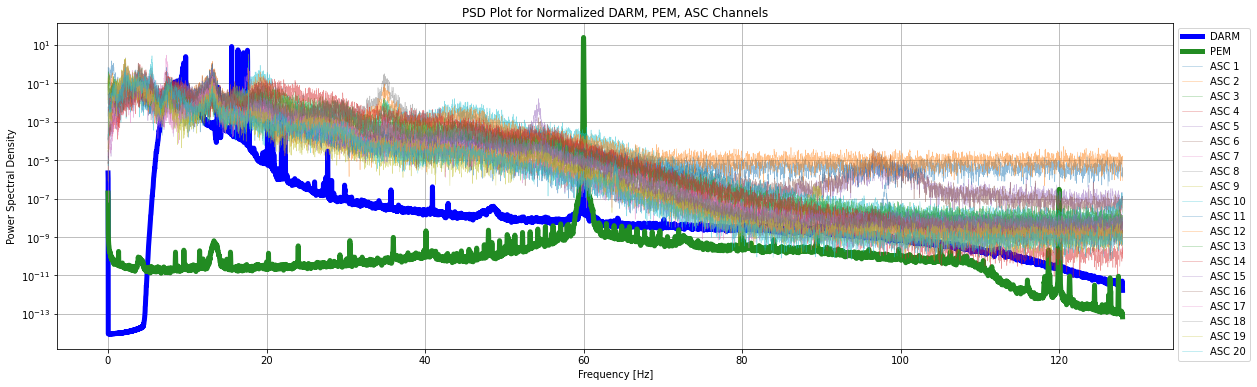

In [29]:
# visualize darm, pem, asc PSDs
fig = plt.figure(figsize=(20,6))
freqs, darm_psd = sig.welch(darm, fs=fs_fast, nperseg=fs_fast*60)
_, mains_psd = sig.welch(pem, fs=fs_fast, nperseg=fs_fast*60)
_, asc1_psd = sig.welch(asc[0 ,:], fs=fs_fast, nperseg=fs_fast*60)
plt.semilogy(freqs, darm_psd.flatten(), label='DARM', c='b', lw=5)
plt.semilogy(freqs, mains_psd.flatten(), label='PEM', c='forestgreen', lw=5)
for i in range(asc.shape[0]):
  _, asc_psd = sig.welch(asc[i ,:], fs=fs_fast, nperseg=fs_fast*60)
  plt.semilogy(freqs, asc_psd.flatten(), label='ASC {}'.format(i+1), alpha=0.5, lw=0.5)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.grid(True)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density')
plt.title('PSD Plot for Normalized DARM, PEM, ASC Channels')
plt.show()
plt.close()

This looks much better and easier to work with. Now, we run the same neural networks we ran on our sample data on this data and observe our results.

# Linear NN (Not Recommended!)

# NN with ReLU / ELU

# Simple RNN w/ ReLU Layer

# LSTM